# Initial Zillow Clustering Project Notebook 

In [1]:
import pandas as pd
import numpy as np

# Vis tools
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Modules

# stats and modeling tools
from sklearn.cluster import KMeans
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# supress scientific notation
np.set_printoptions(suppress=True)

# silence warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set and use zillow color palette
zpalette = ['#1277e1', '#f3ad35', '#0b449c', '#5289e4', '#c3eafb']
sns.set_palette(zpalette)
sns.color_palette()

[(0.07058823529411765, 0.4666666666666667, 0.8823529411764706),
 (0.9529411764705882, 0.6784313725490196, 0.20784313725490197),
 (0.043137254901960784, 0.26666666666666666, 0.611764705882353),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.7647058823529411, 0.9176470588235294, 0.984313725490196)]

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Project Goals and Ideas
### The Big Question: What is driving the errors in the Zestimates?

For this project the target is `logerror`

#### Goal: Identify Drivers of Error and Create model(s) that account for those drivers.

#### Initial Thoughts
- After only looking at size (bedroom count, bathroom count and square footage for the house itself) model was not great
- Location is very important in real estate. As they say Location Location Location
    - Use Latitude and Longitude to narrow down groups
    - Create clusters of error based on location
    - if that doesn't work, try to use location data and price to create neighborhood clusters  
- Price per square foot is something lots of realtors use for comparing houses that aren't the same size 
    - Create engineered feature, `ppsqft` divide `taxvalue` / `calculatedfinishedsquarefeet` 
- Age of home is important when comparing houses, realtors will compare houses built before 1978, between 1798-2000 and post 2000
    - Create engineered feature age, based on year built
    - Create three bins
- Related to size of home, homes typically get compared with other homes within a 400sqft variance. Possibility here to create size clusters based on `calculatedfinishedsquarefeet`, or `ppsft`, or `lotsize`

In [9]:
# defining some functions to make it easier. will go in Wrangle function
from env import host, password, user
import os

###################### Getting database Url ################
def get_db_url(db_name, user=user, host=host, password=password):
    """
        This helper function takes as default the user host and password from the env file.
        You must input the database name. It returns the appropriate URL to use in connecting to a database.
    """
    url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
    return url

######################### get generic data #########################
def get_any_data(database, sql_query):
    '''
    put in the query and the database and get the data you need in a dataframe
    '''

    return pd.read_sql(sql_query, get_db_url(database))

######################### get Zillow Data #########################
def get_zillow_data():
    '''
    This function reads in Zillow data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    sql_query = """
                SELECT parcelid, airconditioningtypeid, airconditioningdesc, architecturalstyletypeid, architecturalstyledesc,
                bathroomcnt, bedroomcnt, buildingclasstypeid, buildingclassdesc, buildingqualitytypeid,
                decktypeid, calculatedfinishedsquarefeet, fips, fireplacecnt, fireplaceflag, garagecarcnt, garagetotalsqft,
                hashottuborspa, latitude, longitude, lotsizesquarefeet, poolcnt, poolsizesum, propertycountylandusecode,
                propertylandusetypeid, propertylandusedesc, propertyzoningdesc, rawcensustractandblock, 
                regionidcity, regionidcounty, regionidneighborhood, roomcnt, threequarterbathnbr, typeconstructiontypeid, typeconstructiondesc, unitcnt, yearbuilt, numberofstories, structuretaxvaluedollarcnt, taxvaluedollarcnt, assessmentyear, 
                landtaxvaluedollarcnt, taxamount, censustractandblock, logerror, transactiondate 
                FROM properties_2017 AS p
                JOIN predictions_2017 USING (parcelid)
                INNER JOIN (SELECT parcelid, MAX(transactiondate) AS transactiondate
                FROM predictions_2017
                GROUP BY parcelid) 
                AS t USING (parcelid, transactiondate)
                LEFT JOIN airconditioningtype USING (airconditioningtypeid)
                LEFT JOIN architecturalstyletype USING (architecturalstyletypeid)
                LEFT JOIN buildingclasstype USING (buildingclasstypeid)
                LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
                LEFT JOIN propertylandusetype USING (propertylandusetypeid)
                LEFT JOIN storytype USING (storytypeid)
                LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
                WHERE latitude IS NOT NULL AND longitude IS NOT NULL 
                AND transactiondate LIKE "2017%%";
                """
    if os.path.isfile('zillow_data.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow_data.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = pd.read_sql(sql_query, get_db_url('zillow'))
        
        # Cache data
        df.to_csv('zillow_data.csv')

    return df

In [10]:
def overview(df, thresh = 10):
    '''
    This function takes in a dataframe and prints out useful things about each column.
    Unique values, value counts for columns less than 10 (can be adjusted with optional arguement thresh)
    Whether or not the row has nulls
    '''
    # create list of columns
    col_list = df.columns
    
    # loop through column list
    for col in col_list:
        # seperator using column name
        print(f'============== {col} ==============')
        
        # print out unique values for each column
        print(f'# Unique Vals: {df[col].nunique()}')
        
        # if number of things is under or equal to the threshold  print a value counts
        if df[col].nunique() <= thresh:
            print(df[col].value_counts(dropna = False).sort_index(ascending = True))
            
        # if the number is less than 150 and not an object, bin it and do value counts
        elif (df[col].nunique() < 150) and df[col].dtype != 'object' :
            print(df[col].value_counts(bins = 10, dropna=False).sort_index(ascending = True))
        
        # Space for readability 
        print('')
       

In [11]:
# I saw this on the afore mentioned kaggle site. This is the credit that author gave.
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
    '''
    this function takes a dataframe as input and will output metrics for missing values, 
    and the percent of that column that has missing values
    '''
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")
        
        # Return the dataframe with missing information
    return mis_val_table_ren_columns

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Get the Data and Overview
- Shape of data
- Number unique values
- Distribution of values
- Null Value exploration

In [76]:
# get zillow data with function above
df = get_zillow_data()

In [13]:
# have a total of 77380 rows 46 columns
df.shape

(77380, 46)

In [15]:
# see the names and types of all columns
# Lots of Nulls to deal with
# might need to do some splitting up vx object, float and int
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77380 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   airconditioningdesc           24953 non-null  object 
 3   architecturalstyletypeid      206 non-null    float64
 4   architecturalstyledesc        206 non-null    object 
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingclassdesc             15 non-null     object 
 9   buildingqualitytypeid         49671 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  calculatedfinishedsquarefeet  77184 non-null  float64
 12  fips                          77380 non-null  float64
 13  f

In [16]:
overview(df)

============== parcelid ==============
# Unique Vals: 77380

============== airconditioningtypeid ==============
# Unique Vals: 5
1.0     23133
5.0       167
9.0        26
11.0       53
13.0     1574
NaN     52427
Name: airconditioningtypeid, dtype: int64

============== airconditioningdesc ==============
# Unique Vals: 5
Central          23133
None               167
Refrigeration       26
Wall Unit           53
Yes               1574
NaN              52427
Name: airconditioningdesc, dtype: int64

============== architecturalstyletypeid ==============
# Unique Vals: 5
2.0         5
3.0         3
7.0       172
8.0        19
21.0        7
NaN     77174
Name: architecturalstyletypeid, dtype: int64

============== architecturalstyledesc ==============
# Unique Vals: 5
Bungalow             5
Cape Cod             3
Contemporary       172
Conventional        19
Ranch/Rambler        7
NaN              77174
Name: architecturalstyledesc, dtype: int64

============== bathroomcnt ==============
#

#### Takeaways
- not sure what roomcnt is and how it's different from bedrooms and bathrooms 
- three quarter bath seems redundant 
- most of the homes here are single family 
- there's someone who has a 14 car garage (maybe it's a quadruplex or something)
- three houses have 5 fireplaces. Must be really cold there in Southern California
- Date could be changed to a datetime object

### Taking a look at Nulls

In [17]:
missing_values_table(df)

Your selected dataframe has 46 columns.
There are 31 columns that have missing values.


,Missing Values,% of Total Values
buildingclasstypeid,77365,100.0
buildingclassdesc,77365,100.0
fireplaceflag,77208,99.8
architecturalstyletypeid,77174,99.7
architecturalstyledesc,77174,99.7
typeconstructiondesc,77158,99.7
typeconstructiontypeid,77158,99.7
decktypeid,76766,99.2
poolsizesum,76513,98.9
hashottuborspa,75842,98.0


#### Takeaways from NaNs
- buildingclassdesc and buildingclasstypeid have too many missing, will drop
- fireplaceflag seems to not have been used as much as fireplacecnt (drop fireplaceflag)
- the architectural columns also don't have enough to go on, nothing to replace with
- typeconstructiondesc and typeconstructiontypeid both don't have enough values (these are things like concrete, masonry)
    - This could be interesting later down the road to classify luxury home
- decktypeid, poolsizesum 
- numberofstories doesn't seem like something would be a driver of price 

Turned to 0s 
- hashottuborspa Nan's could be turned to 0s 
- fireplacecnt 
- garagecarcnt can have NaN's converted to 0s 


###  Functions for Nulls 

In [18]:
def nulls_by_row(df):
    '''
    This function takes in a dataframe and returns a dataframe with an overview of how many rows have missing values
    '''
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = round(num_missing / df.shape[1] * 100, 2)
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing


In [45]:
nulls_by_row(df)

,num_cols_missing,percent_cols_missing,num_rows
0,9,19.57,2
1,10,21.74,10
2,11,23.91,23
3,12,26.09,62
4,13,28.26,114
5,14,30.43,416
6,15,32.61,5577
7,16,34.78,10549
8,17,36.96,14385
9,18,39.13,21032


In [20]:
# see what kind of property land use ids we have 
df.propertylandusedesc.value_counts(dropna = False).to_frame()

,propertylandusedesc
Single Family Residential,52319
Condominium,19294
"Duplex (2 Units, Any Combination)",2009
Planned Unit Development,1944
"Quadruplex (4 Units, Any Combination)",727
"Triplex (3 Units, Any Combination)",535
Cluster Home,333
Mobile Home,74
"Manufactured, Modular, Prefabricated Homes",58
Residential General,37


In [77]:
# put in wrangle module
def single_homes(df):
    '''
    Function takes in zillow dataframe and outputs dataframe with only data for single unit homes.
    Single unit home defined as any of the following 
    'Single Family Residential', 'Townhouse', 'Manufactured, Modular, Prefabricated Homes', 'Mobile Home'
    Home must also have unit count of 1 or NaN
    '''
    # define single home descriptions
    single_homes = ['Single Family Residential', 'Townhouse', 'Manufactured, Modular, Prefabricated Homes', 'Mobile Home']
    
    # If the property land use description is the in the single homes list keep it
    df = df[df['propertylandusedesc'].isin(single_homes)]
    
    # create mask if unit count is 1 or NaN
    unitcnt_mask = (df['unitcnt'] == 1) | (df['unitcnt'].isnull())
    
    # apply mask to dataframe
    df = df[unitcnt_mask]
    
    return df
    

In [78]:
# after filtering for single family homes there are now 52,429 data points to look at
df = single_homes(df)
df.shape

(52429, 46)

In [83]:
# put in wrangle
def drop_missing(df, min_col_percent= 0.65, min_row_percent = 0.85):
    '''
    This columns takes in a dataframe and outputs one with nulls dropped
    The minimum col percent is how many null values you would like to have in your columns for them to stay
    min_row_percent will be how many values must be not null in order to keep that row
    '''
    # calculate columns threshold (any columsn that have more nulls than this, dropped)
    col_thresh = int(round(min_col_percent*df.shape[0]))
    
    # drop coulmns 
    df = df.dropna(axis=1, thresh=col_thresh)
    
    # calculate row threshold 
    row_thresh = int(round(min_row_percent * df.shape[1]))
    
    # drop rows
    
    df = df.dropna(axis=0, thresh=row_thresh)
    
    return df

In [84]:
df_dropped = drop_missing(df)

In [85]:
df_dropped.shape

(52426, 24)

In [86]:
missing_values_table(df_dropped)

Your selected dataframe has 24 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
regionidcity,1033,2.0
lotsizesquarefeet,370,0.7
yearbuilt,130,0.2
censustractandblock,115,0.2
calculatedfinishedsquarefeet,98,0.2
structuretaxvaluedollarcnt,88,0.2
taxamount,4,0.0
landtaxvaluedollarcnt,2,0.0
taxvaluedollarcnt,1,0.0


### Nan Takeaways
- Before just outright dropping either more rows, I will dive into feature engineering and dropping outliers to see if this takes care of some of these still missing values
- Then can impute or drop columns all together (I might not need yearbuilt, or regionidcity)
- Right now have 52,426 houses to look at 

## Feature Engineering 
- create age and yearbuilt bins
- create `ppsqft` 
- create `county` column from `fips`
- create `taxrate`

In [31]:
# create age column 
# subtract 2017 (year the house sold), from year built

def get_house_age(df):
    '''
    This function takes in the Zillow dataframe, and uses the yearbuilt column
    to create new column called 'age'. 
    Outputs dataframe with new 'age' column attched.
    '''
     
    df['age'] = 2017 - df['yearbuilt']
    
    return df

In [91]:
# use function on dataframe
df = get_house_age(df_dropped)

In [35]:
# create age bins 
def yearbuilt_bins(df):
    '''
    Function takes in a dataframe, uses the 'yearbuilt' column to create age bins
    pre 1978, 1978-2000, and post 2000 
    '''
    # set bin sizes
    year_bins = [df['yearbuilt'].min(), 1978, 2000,df['yearbuilt'].max()]
    
    # use cut to assign bins using yearbuilt column
    df['yearbuilt_bins'] = pd.cut(df['yearbuilt'], year_bins)
    
    return df

In [92]:
# use function to create bins
df = yearbuilt_bins(df)

In [40]:
def ppsqft(df):
    '''
    This function takes in a dataframe and uses the 'calculatedfinishedsquarefeet' and 'taxvaluedollarcnt' columns
    to create new ppsqft column
    '''
    # create new column and do math
    df['ppsqft'] = round(df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet'], 2)
    
    return df

In [93]:
df = ppsqft(df)

In [98]:
def cali_counties(df):
    '''
    This function takes in the zillow dataframe, uses the fips column and a dictionary of counties
    and adds a column called county with where the house is located
    returns a dataframe with the column attached 
    '''
    # make dictionary with fips values and county names
    counties = {6037: 'LA', 6059: 'Orange', 6111: 'Ventura'}

    # use .replace to create an new column called county
    df['county'] = df.fips.replace(counties)

    return df

In [99]:
df = cali_counties(df)

In [129]:
def get_tax_rate(df):
    '''
    Function takes in dataframe and returns with tax_rate column attched
    '''
    df['tax_rate'] = round(df['taxamount'] / df['taxvaluedollarcnt'] * 100, 2)
    
    return df

In [130]:
df = get_tax_rate(df)

## Explore to look for outliers and other useful things

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52426 entries, 0 to 77379
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   parcelid                      52426 non-null  int64   
 1   bathroomcnt                   52426 non-null  float64 
 2   bedroomcnt                    52426 non-null  float64 
 3   calculatedfinishedsquarefeet  52328 non-null  float64 
 4   fips                          52426 non-null  float64 
 5   latitude                      52426 non-null  float64 
 6   longitude                     52426 non-null  float64 
 7   lotsizesquarefeet             52056 non-null  float64 
 8   propertycountylandusecode     52426 non-null  object  
 9   propertylandusetypeid         52426 non-null  float64 
 10  propertylandusedesc           52426 non-null  object  
 11  rawcensustractandblock        52426 non-null  float64 
 12  regionidcity                  51393 non-null  

In [121]:
# put in explore module
def plot_variable_dist(df, figsize = (3,2)):
    '''
    This function is for exploring. Takes in a dataframe with variables you would like to see the distribution of.
    Input the dataframe (either fully, or using .drop) with ONLY the columns you want to see plotted. 
    Optional argument figsize. Default it's small. 
    BTW if you just put list(df) it pulls out only the column names
    '''
    # loop through columns and use seaborn to plot distributions
    for col in list(df):
            plt.figure(figsize=figsize)
            plt.hist(data = df, x = col)
            plt.title(f'Distribution of {col}')
            plt.show()
            print(f'Number of Nulls: {df[col].isnull().sum()}')

###  Takeaways from distributions
- `regionidcounty` seems to be the same as `fips`, drop it because it's missing values
- 'regionidcity'
- 'assessmentyear' isn't of value for this purpose 
- yearbuilt can impute missing values with median or mean

In [122]:
def plot_boxes(df, figsize = (4,2)):
    '''
    This function is for exploring. Takes in a dataframe with variables you would like to see the box plot of.
    Input the dataframe (either fully, or using .drop) with ONLY the columns you want to see plotted.
    Will skip over object columns automatically.
    Optional arguement figsize. Default it's small.    
    '''

    for col in list(df):
        if df[col].dtypes != object: 
            plt.figure(figsize=figsize)
            sns.boxplot(data = df, x = col)
            plt.title(f'Box Plot of {col}')
            plt.show()
        else:
            print(f'{col} is an object type')

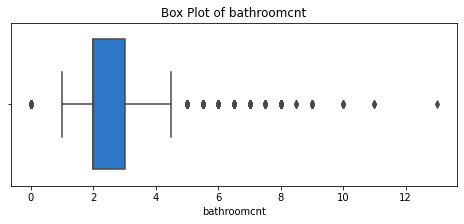

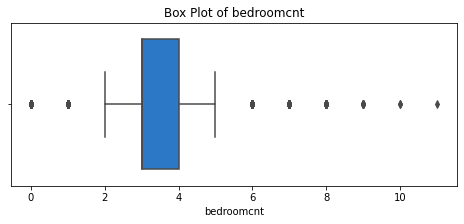

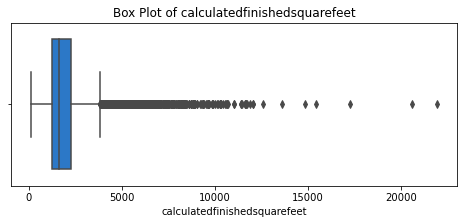

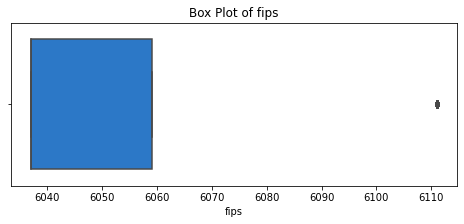

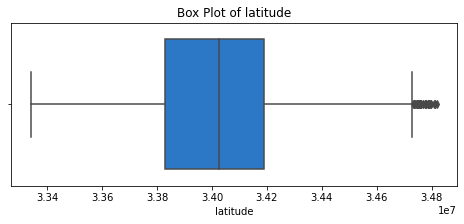

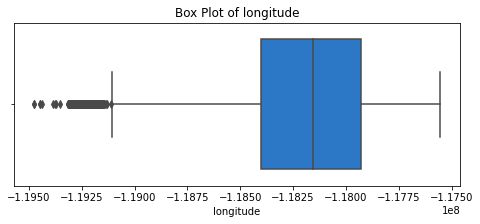

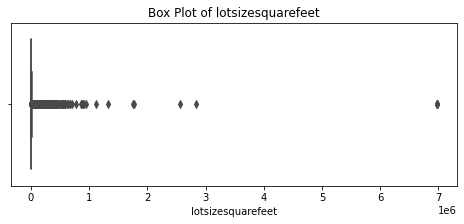

propertycountylandusecode is an object type


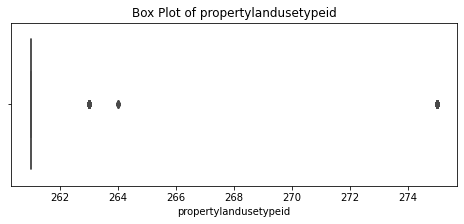

propertylandusedesc is an object type


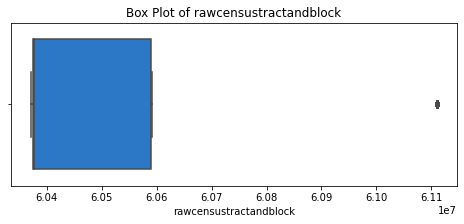

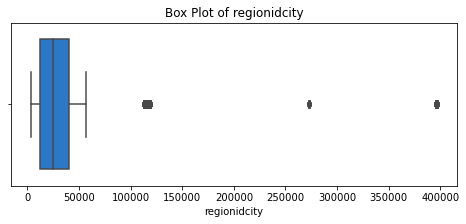

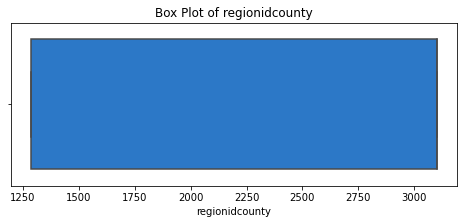

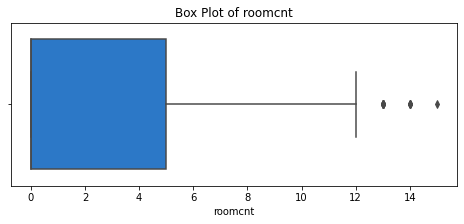

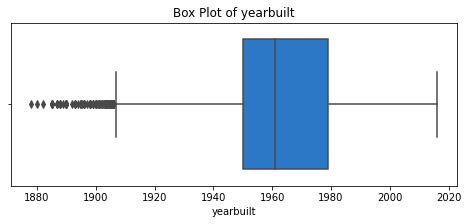

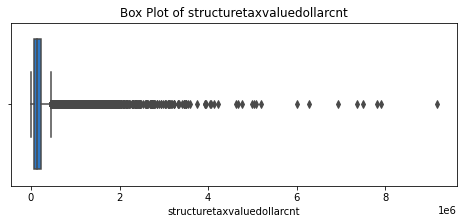

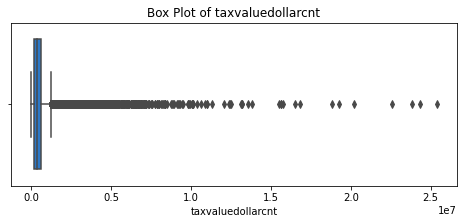

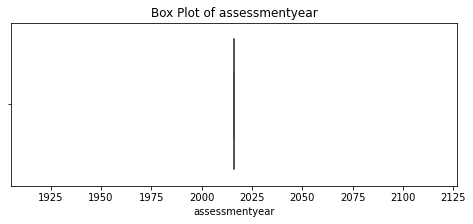

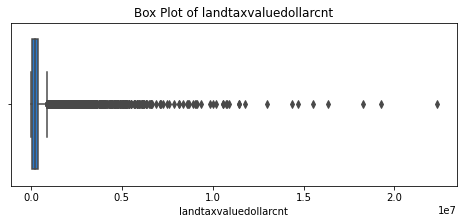

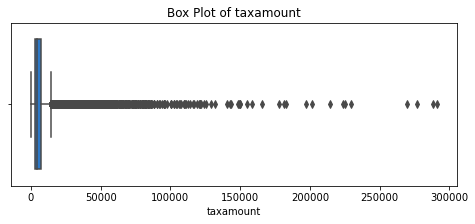

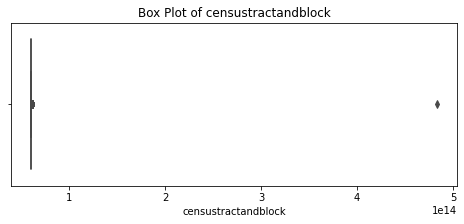

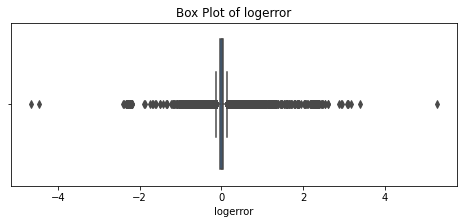

transactiondate is an object type


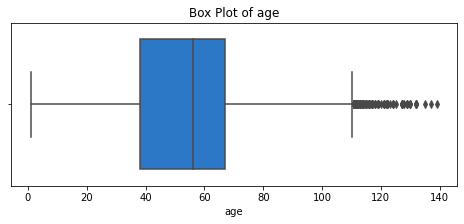

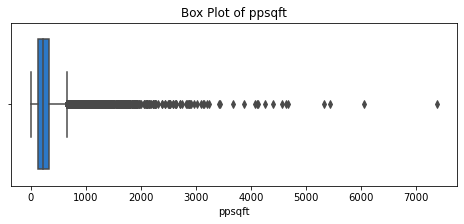

county is an object type


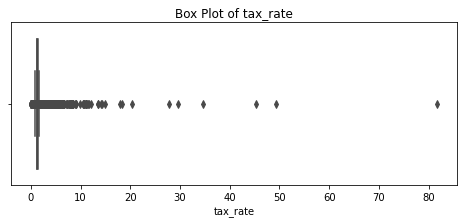

In [133]:
plot_boxes(df.drop(columns = ['parcelid', 'yearbuilt_bins']), figsize = (8,3))

### Takeaways and what to do with outliers
- There's a lot of homes on the upper end (i.e. really expensive, really large, lots of bedrooms, lots of bathrooms) 
- Will drop outliers 
- who has a tax rate of 80% 
- Drop everyone with a weird tax rate, bedroomcnt must be between 1 and 7, bathroomcnt must be between 1 and 6 
- then add everyone with a calculatedfinishedsquarefeet above 3 standard deviations and taxamount

In [167]:
def remove_outlier_z(df, z = 3, col_list):
    '''
    This function takes in a dataframe
    It outputs a the dataframe with the outliers that have a Z score above 3 or below -3 removed
    Can change z score with z =. default is 3
    '''
    for col in col_list:
        
        df = df[(np.abs(stats.zscore(df)) < z).all(axis=1)]
        
    return df

In [169]:
def remove_outliers(df, k, col_list):
    '''
    This function takes in a dataframe, k value, and column list and 
    k = number times interquartile range you would like to remove
    col_list = names of columns you want outliers removed from
    removes outliers from a list of columns in a dataframe 
    and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[f'{col}'].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]
        
    return df

In [226]:
def drop_zillow_outliers(df):
    '''
    '''
    
    return df[((df.bathroomcnt <= 6) & (df.bathroomcnt > 0) & 
        (df.bedroomcnt <= 7) & (df.bedroomcnt > 0) & 
        (df.tax_rate < 15))]

In [227]:
df.shape

(52426, 29)

In [235]:
df2 = drop_zillow_outliers(df)

In [236]:
df2.shape

(51983, 29)

In [237]:
col_list = ['calculatedfinishedsquarefeet', 'taxamount']

df2 = remove_outliers(df2, 3, col_list)

In [238]:
df2.shape

(50265, 29)

In [239]:
missing_values_table(df2)

Your selected dataframe has 29 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
regionidcity,1001,2.0
lotsizesquarefeet,320,0.6
censustractandblock,98,0.2
structuretaxvaluedollarcnt,51,0.1
yearbuilt_bins,32,0.1
yearbuilt,31,0.1
age,31,0.1


In [247]:
def drop_unneeded_cols(df, unneeded_cols = ['lotsizesquarefeet', 'regionidcity', 'regionidcounty', 'assessmentyear']):
    '''
    This function takes in a dataframe and a list of unneeded columns (default is for zillow data)
    Returns dataframe with those columns dropped
    '''
    df = df.drop(columns = unneeded_cols)
    
    return df

In [248]:
def drop_rows_low_percent(df):
    '''
    Finds columns with missing values less than 1 percent. Drops all rows with missing values in those rows.
    '''
    
    has_percent_below_one = ((df.isnull().sum() / df.shape[0]) < .01)
    
    one_percenters = list(has_percent_below_one[has_percent_below_one == True].index)
    
    df = df.dropna(axis=0, subset=one_percenters)
    
    return df

In [249]:
df2 = drop_unneeded_cols(df2)

In [250]:
df2 = drop_rows_low_percent(df2)

In [251]:
missing_values_table(df2)

Your selected dataframe has 27 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Move all functions to Wrangle file

In [3]:
import wrangle as w

In [4]:
# still need to split table
df = w.wrangle_zillow()

In [5]:
w.missing_values_table(df)

Your selected dataframe has 25 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [6]:
df.shape

(46466, 25)

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Explore

- Split data
- Goals explore and make clusters 
- Run stats tests


In [7]:
train, validate, split = w.banana_split(df)

train --> (26020, 25)
validate --> (11152, 25)
test --> (9294, 25)


In [8]:
def plot_cat_and_cont(df, cat_vars, cont_vars):
    '''
    df = dataframe you're graphing
    This function takes in a list of categorical variables and continuous variable and plots a swarm plot, box plot, and violin plot for each pair
    '''
    # multiply length of continuous variables and length of categorical variables. This is the amount of rows in subplot, and helps set figsize to be tall enough
    num_graphs = len(cont_vars) * len(cat_vars)
    
    # set up figure and axes subplot stuff. Figsize height will adjust to number of rows there should be
    fig, axes = plt.subplots(num_graphs, 3, figsize = (20 , (num_graphs * 5)), squeeze = False)
    
    #initialize my row counter
    row = 0
    
    # loop through continuous variables
    for cont in cont_vars:
        
        # inner loop through categorical variables
        for cat in cat_vars:
            
            # plot all three plots (can change which ones you would like to use here)
            # [row] is the row number we're on, [0] is left most graph in subplot
            sns.swarmplot(x=cat, y=cont, data=df, ax = axes[row][0])
            axes[row][0].set_title(f'{cat} and {cont}')
            
            sns.boxplot(x=cat, y=cont, data=df, ax = axes[row][1])
            axes[row][1].set_title(f'{cat} and {cont}')
            
            sns.violinplot(x = cat, y = cont, data =df, ax = axes[row][2])
            axes[row][2].set_title(f'{cat} and {cont}')
        
            # add one to row to move to next row for the next round
            row = row + 1
            
            # loading check can take out this line
            print(f'Working ---- {row}')
    # show it all
    plt.show()

In [9]:
target = 'logerror'

variables = ['bathroomcnt',
            'bedroomcnt',
            'calculatedfinishedsquarefeet',
            'ppsqft',
            'latitude',
            'longitude',
            'roomcnt',
            'structuretaxvaluedollarcnt',
            'taxvaluedollarcnt',
            'landtaxvaluedollarcnt',
            'taxamount',
            'age',
            'tax_rate']

<AxesSubplot:xlabel='bathroomcnt', ylabel='logerror'>

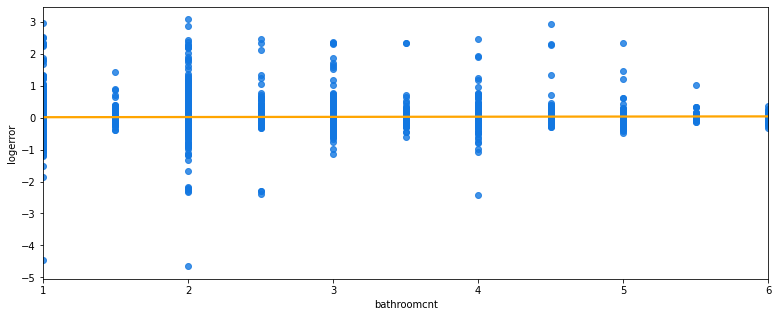

In [10]:
plt.figure(figsize = (13,5))
sns.regplot(data = train, x = 'bathroomcnt', y = target, line_kws={'color': 'orange'})

In [11]:
def plot_against_target(df, target, var_list, figsize = (10,5), hue = None):
    '''
    Takes in dataframe, target and varialbe list, and plots against target. 
    '''
    for var in var_list:
        plt.figure(figsize = (figsize))
        sns.regplot(data = df, x = var, y = target, 
                    line_kws={'color': 'orange'})
        plt.show()


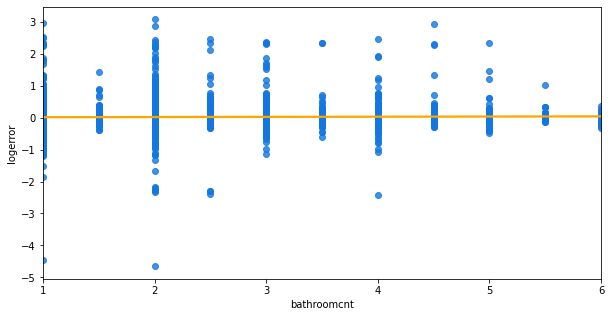

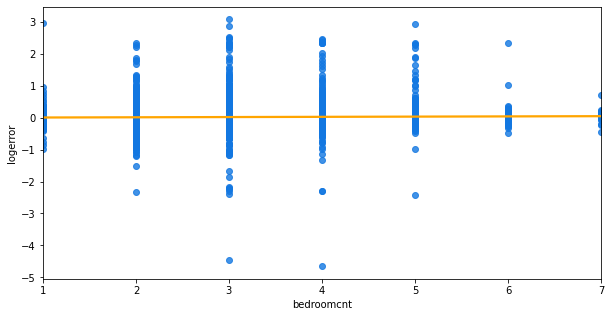

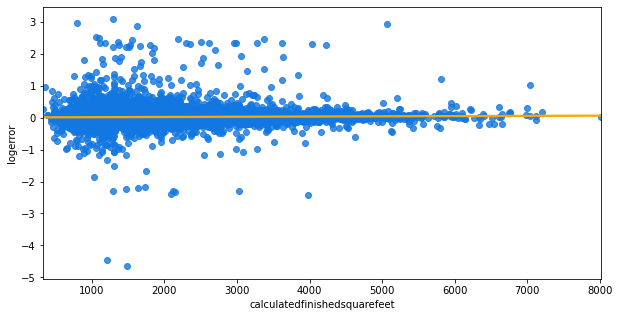

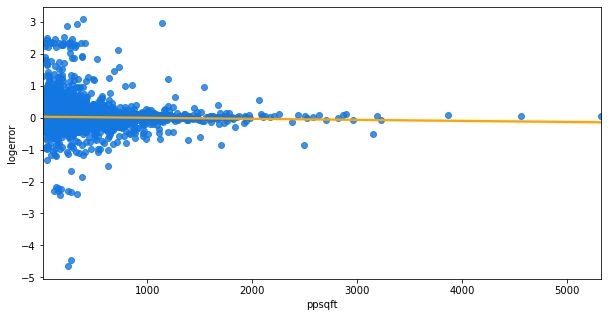

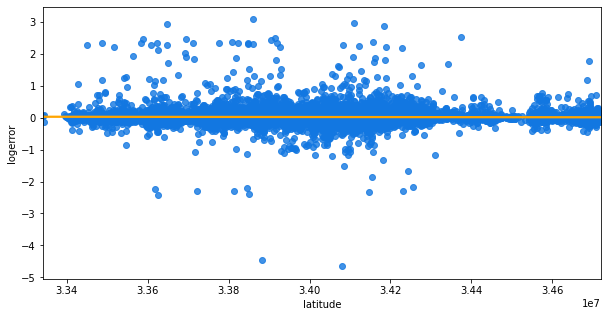

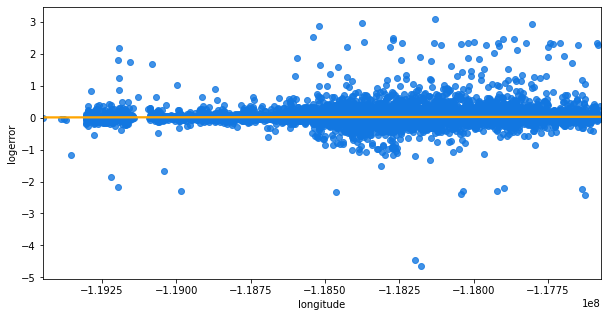

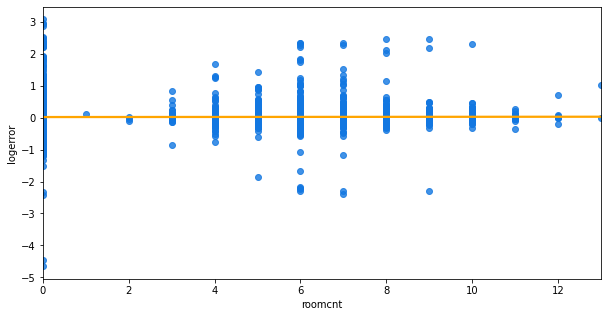

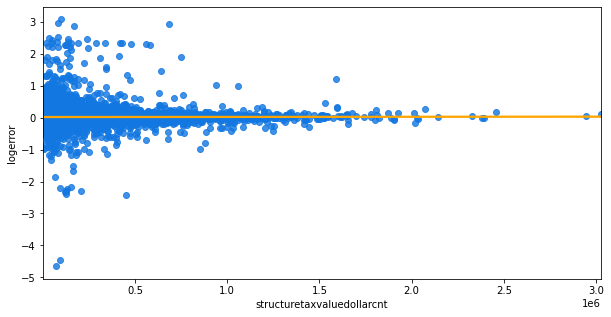

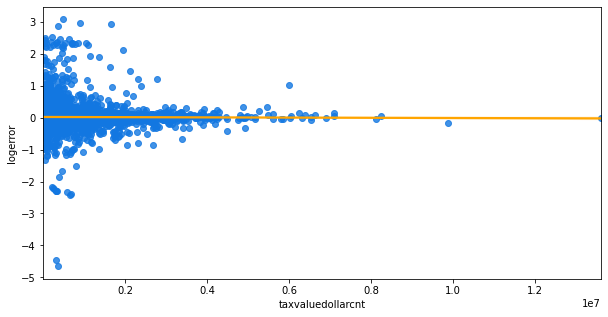

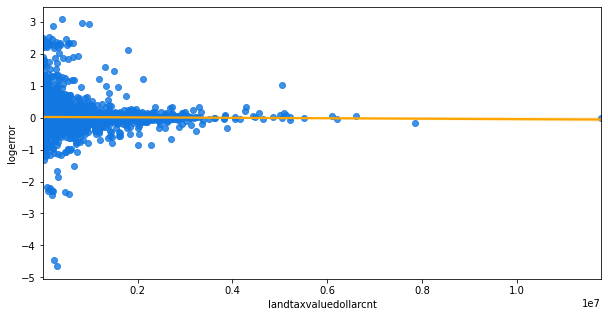

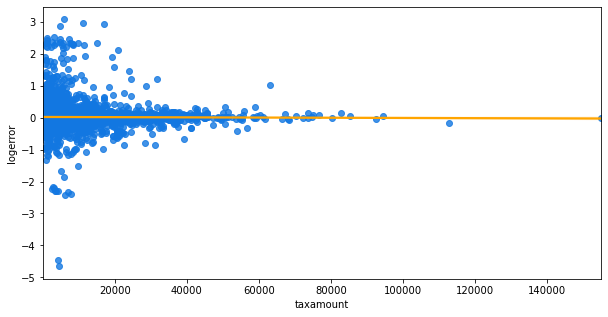

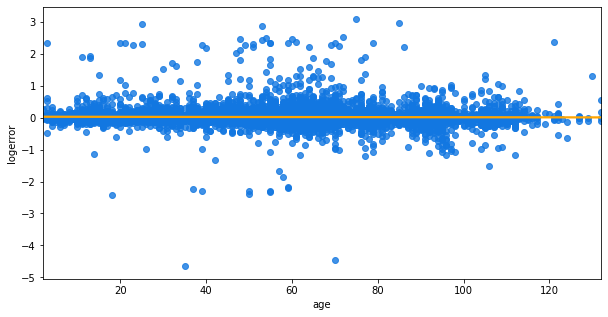

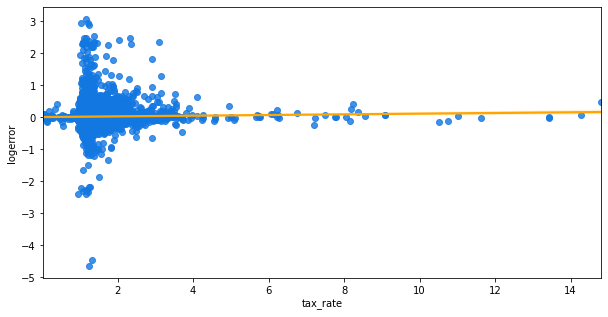

In [12]:
plot_against_target(train, target, variables)

### Takeaways
- When taxrate is high, logerror is under guessing
- when taxrate is low, more homes seem to be under guessed 
- Also not very much other info gleaned from this


In [14]:
col_list = variables
col_list.append(target)

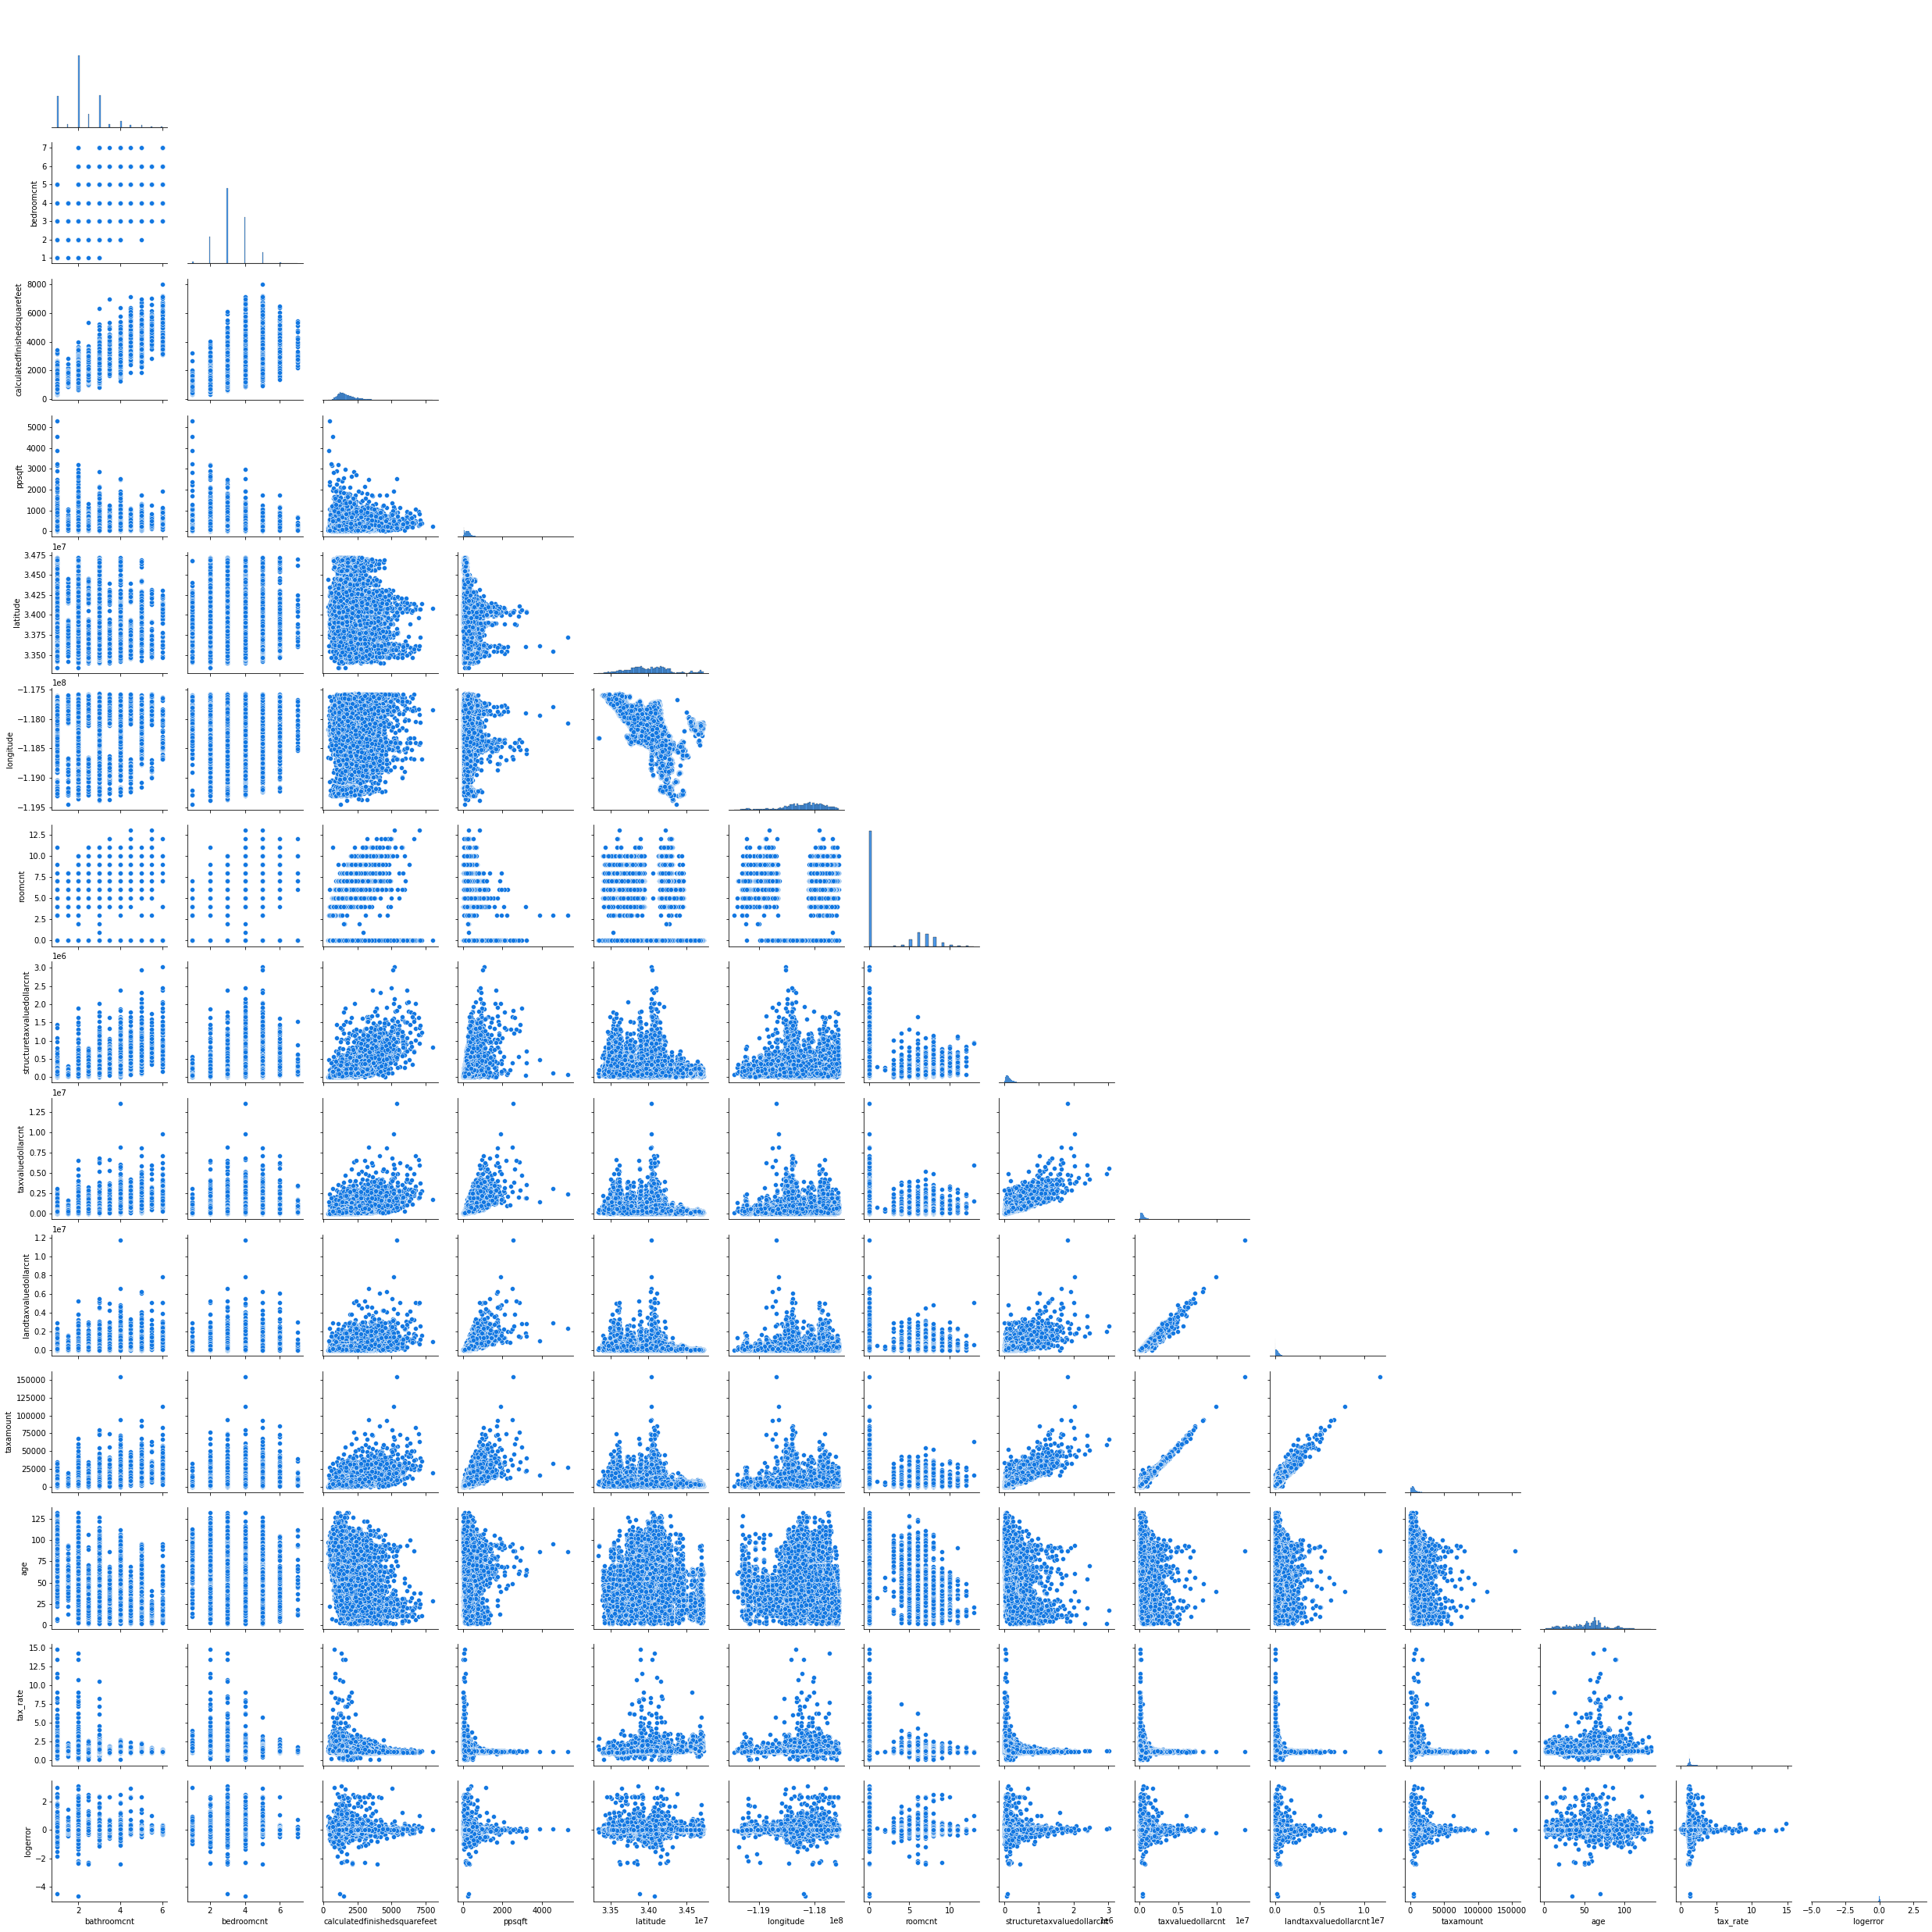

In [15]:
sns.pairplot(data = train[col_list], corner=True)

### Takeaways
- Something weird is going on with `age` and `logerror`
- seems like on the lower end of value log error is high
- Definitely need to cluster log error and lat and long
- wider spread of error on homes under 4000 ish sqft
- Weird errors all the way down on ppsqft and calculated finished sqft


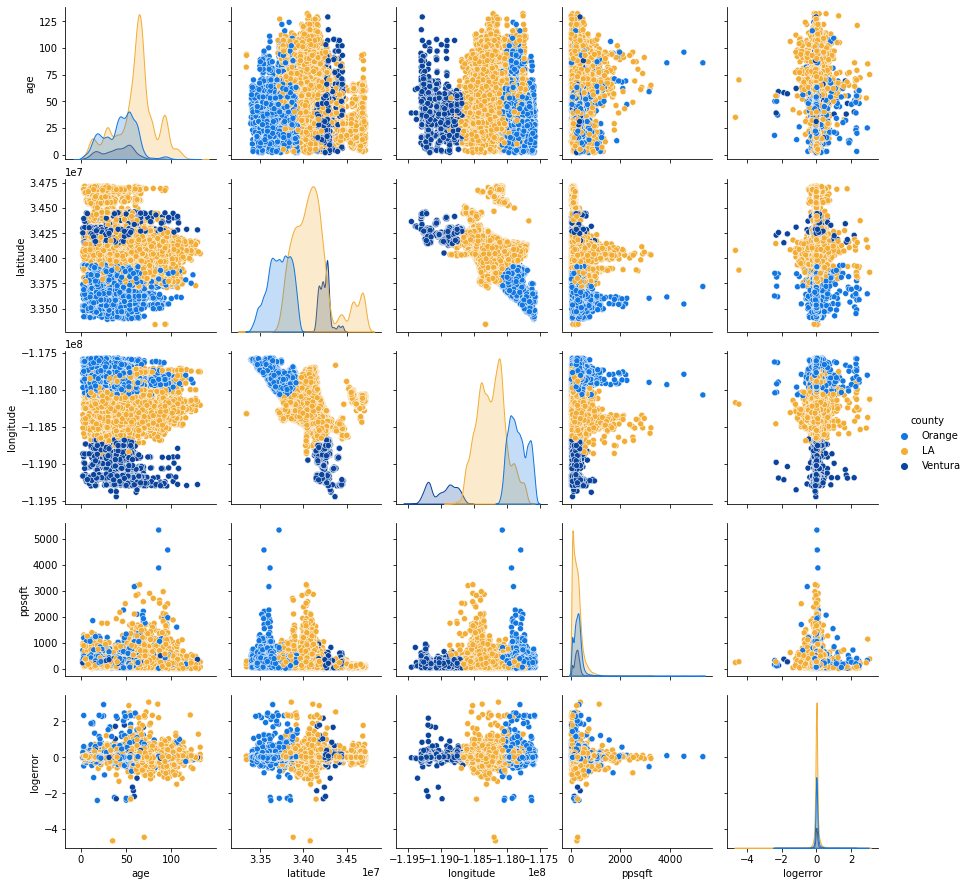

In [15]:
cols = ['age', 'latitude', 'longitude', 'ppsqft', 'logerror', 'county']

sns.pairplot(data = train[cols], hue = 'county')

### Takeaways 
- good zoom in on the spots
- nothing new
- hue by county didn't add much other than, there's a lot in LA county and there's probably going to be a need to break down things by county


## Clustering 
- create clusters using lat long and ppsqft 
- try lat long and age
- try age and ppsqft 
- Maybe try all 4

In [42]:
df = w.wrangle_zillow()

In [43]:
train, validate, test = w.banana_split(df)

train --> (26020, 25)
validate --> (11152, 25)
test --> (9294, 25)


In [44]:
# scale data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_this(X_df, scalertype):
    '''
    X_df = dataframe with columns you need scaled
    scalertype = something like StandardScaler(), or MinMaxScaler()
    This function takes a dataframe (an X data), a scaler, and ouputs a new dataframe with those columns scaled. 
    And a scaler to inverse transforming
    '''
    scaler = scalertype.fit(X_df)

    X_scaled = pd.DataFrame(scaler.transform(X_df), columns = X_df.columns).set_index([X_df.index.values])
    
    return X_scaled, scaler

In [45]:
X_train = train[['age', 'latitude', 'longitude']]

X_train_scaled, mm_scaler = scale_this(X_train, MinMaxScaler())

In [46]:
X_train_scaled.head()

,age,latitude,longitude
43556,0.215385,0.392293,0.889440
60829,0.292308,0.365318,0.907825
18348,0.707692,0.559420,0.638175
58919,0.076923,0.143593,0.964776
6754,0.046154,0.618844,0.108008


In [47]:
def makin_clusters(X_df, k, col_name = None ):
    '''
    Function takes in scaled dataframe, k number of clusters you want to make
    Optional arguemenet col_name, If none is entered column returned is {k}_k_clusters
    Returns dataframe with column attched and dataframe with centroids (scaled) in it
    '''
    
    #make thing
    kmeans = KMeans(n_clusters=k, random_state=713)

    #Fit Thing
    kmeans.fit(X_df)
    
    centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = list(X_df))
    
    if col_name == None:
        #clusters on dataframe 
        X_df[f'{k}_k_clusters'] = kmeans.predict(X_df)
    else:
        X_df[col_name] = kmeans.predict(X_df)
        
    
    return X_df, centroids_scaled, kmeans

In [48]:
# create kMeans 
X_train, centroids_scaled, kmeans = makin_clusters(X_train_scaled, 4)

In [52]:

def plot_clusters(x ,y, cluster_col_name, df , kmeans, scaler, centroids):
    
    """ Takes in x and y (variable names as strings, along with returned objects from previous
    function create_cluster and creates a plot"""
    
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(x = x, y = y, data = df, hue = cluster_col_name)
    
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black', marker = 'x')

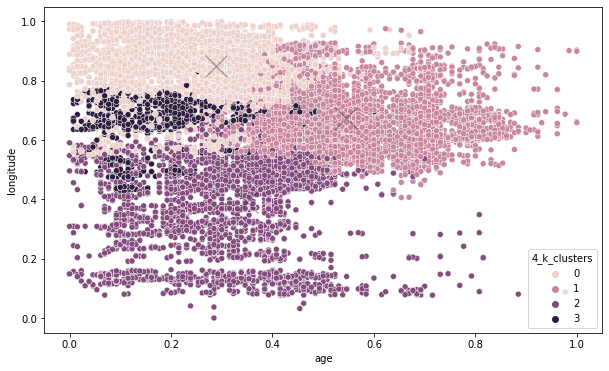

In [55]:
plot_clusters('age', 'longitude', '4_k_clusters', X_train, kmeans, mm_scaler, centroids_scaled)

In [ ]:
# pick best one 